**<font  size=6>回測框架</font>**

In [1]:
import backtrader as bt
import backtrader.indicator as btind
import backtrader.feeds as btfeeds
import backtrader.analyzers as btanalyzers
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import argparse
import datetime
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import binance
import gradient_free_optimizers as gfo

#pyfolio 用 pip install git+https://github.com/quantopian/pyfolio 裝，不然會報錯
import pyfolio as pf

**<font  size=5>導入數據</font>**

In [2]:
#下載歷史資料
client = binance.Client()      #先將API實例化方便取用

#撰寫幣安爬蟲API
def data_download(symbol, symbol_class, interval, start_str) :

    if symbol_class == 'spot' :
        klines = client.get_historical_klines(symbol, interval, start_str)
    if symbol_class == 'future' :
        klines = client.futures_historical_klines(symbol, interval, start_str)
    data = pd.DataFrame(klines)
    data.columns = ['open_time', 'open', 'high', 'low', 'close',
    'volume', 'close_time', 'qav', 'num_trades',
    'taker_base_vol', 'taker_base_vol', 'ignore']    
    data.index = [datetime.datetime.fromtimestamp(x/1000.0) for x in data.close_time]
    data.index = data.index + datetime.timedelta(seconds = 0.001)
    data.reset_index(inplace=True)
    data.set_index('index',inplace=True)
    data = data[['open','high','low','close','volume']]
    data['open'] = data['open'].astype(float)
    data['high'] = data['high'].astype(float)
    data['low'] = data['low'].astype(float)
    data['close'] = data['close'].astype(float)
    data['volume'] = data['volume'].astype(float)
    data["openinterest"] = 0
    return data    

#下載歷史資料 data1=期貨 , data2=現貨
data1 = data_download('BTCUSDT','future','30m','2021-01-01')
data2 = data_download('BTCUSDT','spot','30m','2021-01-01')

#用pd函數intersection取出交集，在將交集放入原始資料，使兩者長度相等
idx = data1.index.intersection(data2.index)
data1 = data1.loc[idx]
data2 = data2.loc[idx]

**<font  size=4> 整理成引擎能接受的格式</font>**

In [5]:
params = dict(
            fromdate = datetime.datetime(2021,1,1), # 回測開始時間
            todate = datetime.datetime(2022,11,8),  # 回測結束時間
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和時間格式
            tmformat=('%H:%M:%S'), # 時間格式
            datetime=0, # 下面幾行是導入的數據，要和傳入的數據列進行一一對應，以這個參數為準
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=6)

# 建立datafeed，這裡是從內存的pandasDataFrame，可以有別的來源，詳見bt.feeds
datafeed1 = bt.feeds.PandasDirectData(dataname = data1, **params)
datafeed2 = bt.feeds.PandasDirectData(dataname = data2, **params)

**<font  size=5>定義策略類</font>**

首先說明，這個基於Backtrader框架集成參數優化與可視化的回測方法，策略代碼要編的好必須熟悉基礎的backtrader引擎邏輯，以下幾點說明，詳見backtrader包:
- 策略類中參數必須定義成類變量params -> tuple，其中包含參數tuple，格式要跟我寫的一樣。
- 指標定義成實例變量(__init__方法中)
- 框架中self.datas[i]為你餵入的第i個資產的數據(我們這邊有兩個資產，一個當指標)，self.datas[i].close[0]為你餵入的第i個資產的數據現在這個k線的close價，self.datas[i].close[-1]為上一根的close價，self.datas[i].close[1]為 下一根的close價
- 我所用到的指標計算函數除了我自己定義的，都可以在backtrader.ind找到使用方法

In [125]:
#示範編寫參數方法，這裡只實現一個，其他我直接寫在策略類裡，也可以拉出來實現(我懶)
class difInd(bt.Indicator):
    lines = ('dif',)

    def next(self):
        self.lines.dif[0] = self.datas[0].close[0] - self.datas[1].close[0]

#策略類
class TestStrategy(bt.Strategy):
    #參數，之後優化可能會用到，這邊是默認
    params = (
        ('rolling_window', 130),
        ('tp_ratio', 20),
        ('sl_ratio', 6),
        ('longout', 80),
        ('shortout', 120),
        ('printout', False),#參數，是否打印行情(next中)
    )
    #定義會用到的指標或變量
    def __init__(self):
        # 保留對 data[0] 數據系列中“close”行的引用(為了方便)
        self.dataclose = self.datas[0].close

        #定義變量紀錄買賣價格
        self.buyprice = None
        self.sellprice = None

        #定義變量紀錄委託
        self.lmt_1 = None
        self.lmt_2 = None
        
        #定義各指標
        self.dif = difInd(self.datas[0],self.datas[1])
        self.spread_avg = (bt.ind.Highest(self.dif,period=self.params.rolling_window) - bt.ind.Lowest(self.dif,period=self.params.rolling_window))/2
        self.low = bt.ind.Lowest(self.datas[0].close,period = self.params.rolling_window)
        self.spot_hl = (bt.ind.Highest(self.datas[1].close,period = self.params.rolling_window) - self.low)/2
        self.spot_line = (bt.ind.Highest(self.datas[1].close,period = self.params.rolling_window) + self.low)/2
        self.upper_band = self.spot_line + 0.3*(self.spot_hl+self.spread_avg)
        self.lower_band = self.spot_line - 0.2*(self.spot_hl+self.spread_avg)
        self.lowout = bt.ind.Lowest(self.datas[0].low,period=self.params.longout)
        self.highout = bt.ind.Highest(self.datas[0].high,period =self.params.shortout)
        
        #定義變量紀錄倉位，注意!在每個策略中要有自己的倉位或信號紀錄，不要用backtrader框架中的self.position，不然在多個策略同引擎一起回測時會有問題(A策略開的倉被B策略平掉)
        self.sposition = 0
        
        #定義是否在買賣時點圖中畫出指標
        self.dif.plotinfo.plot = False
        self.low.plotinfo.plot = False
        self.datas[1].plotinfo.plot = False
        self.lowout.plotinfo.plot = True
        self.lowout.plotinfo.subplot = False
        self.highout.plotinfo.plot = True
        self.highout.plotinfo.subplot = False

    def start(self):
        #是否打印K線行情        
        if self.p.printout:
            txtfields = list()
            txtfields.append('Len')
            txtfields.append('Datetime')
            txtfields.append('Open')
            txtfields.append('High')
            txtfields.append('Low')
            txtfields.append('Close')
            txtfields.append('Volume')
            txtfields.append('OpenInterest')
            print(','.join(txtfields))

    #如果有委託產生，就會執行一次
    def notify_order(self, order):

        #如果是提交或是允許，不做任何事(也會有order.status == order.Margin的狀況，如果錢不夠執行你的委託)，詳見backtrader        
        if order.status in [order.Submitted,order.Accepted]:
            return

        #如果是委託成交，執行下面的指令
        if order.status in [order.Completed]:
            
            #如果是買單成交
            if order.isbuy():
                #倉位+=1(初始是0)
                self.sposition +=1
                #記錄買單成交價
                self.buyprice = order.executed.price
                
                #如果倉位是1(也就是開倉)
                if self.sposition == 1:
                    #掛一個Limit的賣單(用self.close來寫或許比較好但我懶得改)，並記錄這個賣單
                    self.lmt_1 = self.sell(exectype= bt.Order.Limit, price = self.buyprice*(1+0.01*self.params.tp_ratio))
                    #掛一個STOP的賣單(用self.close來寫或許比較好但我懶得改)，注意!後面調用oco方法指定上面我們紀錄的Limit賣單，這樣兩個委託(之後還會再綁一個)就會綁在一起，實現一個成交cancel其他委託的功能
                    self.sell(exectype = bt.Order.Stop, price = self.buyprice*(1-0.01*self.params.sl_ratio),oco = self.lmt_1)

            #同上，買變成賣
            elif order.issell():
                self.sposition -=1 
                self.sellprice = order.executed.price
                if self.sposition == -1:
                    self.lmt_2 = self.buy(exectype=bt.Order.Limit, price = self.sellprice*(1-0.01*self.params.tp_ratio))
                    self.buy(exectype=bt.Order.Stop, price= self.sellprice*(1+0.01*self.params.sl_ratio),oco = self.lmt_2)
                    
        
       


    #在這邊可寫可不寫，只是展示一下有這個功能
    def notify_trade(self, trade):
        #部位如果沒close不做任何事
        if not trade.isclosed:
            return


    #核心策略寫在這裡
    def next(self):
        
        if self.p.printout:
            # 僅打印第一個數據...只是檢查是否正在運行
            txtfields = list()
            txtfields.append('%04d' % len(self))
            txtfields.append(self.data.datetime.datetime(0).isoformat())
            txtfields.append('%.2f' % self.datas[0].open[0])
            txtfields.append('%.2f' % self.datas[0].high[0])
            txtfields.append('%.2f' % self.datas[0].low[0])
            txtfields.append('%.2f' % self.datas[0].close[0])
            txtfields.append('%.2f' % self.datas[0].volume[0])
            txtfields.append('%.2f' % self.datas[0].openinterest[0])
            print(','.join(txtfields))



        # 檢查我們是否有部位
        #如果沒有
        if self.sposition ==0:
            #策略條件
            if (self.dataclose[-1] < self.upper_band[0]) & (self.dataclose[0] > self.upper_band[0]) & (self.dataclose[0]*0.01*4 > self.spot_hl[0]):
                #開倉買入
                self.buy(exectype= bt.Order.Limit,price = self.dataclose[0],data = self.datas[0])

            #策略條件
            elif (self.dataclose[-1] > self.lower_band[0]) & (self.dataclose[0] < self.lower_band[0]) & (self.dataclose[0]*0.01*4 > self.spot_hl[0]):
                #開倉賣出
                self.sell(exectype= bt.Order.Limit,price = self.dataclose[0],data = self.datas[0])


        #如果有多倉
        if self.sposition == 1:
            #策略條件
            if self.dataclose[0] <= self.lowout[0]:
                #賣出，oco綁定上面的lmt_1，三個綁在一起，一個成交其他取消
                self.sell(oco = self.lmt_1)

        # 如果有空倉
        if self.sposition == -1:
            #策略條件
            if self.dataclose[0] >= self.highout[0]:
                #買入，oco綁定上面的lmt_2，三個綁在一起，一個成交其他取消
                self.buy(oco = self.lmt_2)



In [113]:
#隨便寫一個策略測試多策略回測
class SmaCross(bt.Strategy):
    params = (
        ('sma1', 10),
        ('sma2', 30),
        ('printout', False),
    )
    def __init__(self):
        SMA1 = bt.ind.SMA(period = self.params.sma1)
        SMA2 = bt.ind.SMA(period = self.params.sma2)
        self.crossover = bt.ind.CrossOver(SMA1, SMA2)
        self.crossover.plotinfo.plot = False
        self.smaposition = 0
        

    def next(self):
        
        if self.p.printout:
            txtfields = list()
            txtfields.append('%04d' % len(self))
            txtfields.append(self.data.datetime.datetime(0).isoformat())
            txtfields.append('%.2f' % self.datas[0].open[0])
            txtfields.append('%.2f' % self.datas[0].high[0])
            txtfields.append('%.2f' % self.datas[0].low[0])
            txtfields.append('%.2f' % self.datas[0].close[0])
            txtfields.append('%.2f' % self.datas[0].volume[0])
            txtfields.append('%.2f' % self.datas[0].openinterest[0])
            print(','.join(txtfields))

            
        if self.smaposition == 0:
            if self.crossover > 0:
                self.buy(data = self.datas[0])

        elif self.smaposition  > 0: 
            if self.crossover < 0:
                self.sell(data= self.datas[0])

    def notify_order(self, order):
        type = "Buy" if order.isbuy() else "Sell"
        
        if order.status in [order.Submitted,order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:

            if order.isbuy():
                self.smaposition +=1 
                
            elif order.issell():
                self.smaposition -=1 

**<font  size=5>功能參數管理</font>**

In [93]:
#功能參數管理
def parse_args(args=None):

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='Sample for pivot point and cross plotting')

    #是否打印
    #給parse_args中輸入的列表中如果有'--printout'，變成True，不然默認False
    parser.add_argument('--printout', required=False, action='store_true',
                        default= False,
                        help=('Print data lines'))
    #是否指定起始資金
    #給parse_args中輸入的列表中可以指定cash，不然默認100000.0
    parser.add_argument('--cash', required=False, action='store',
                        type=float, default=100000.0,
                        help=('Cash to start with'))

    #是否畫買入賣出點圖
    #給parse_args中輸入的列表中如果有'--plot'，變成True，不然默認False
    parser.add_argument('--plot', required=False, action='store_true',
                        default= False, 
                        help=('Plot the result'))

    #給parse_args中輸入的列表中可以指定plotstyle，不然默認'bar'
    #這個是畫買入賣出點圖的
    parser.add_argument('--plot-style', required=False, action='store',
                        default='bar', choices=['bar', 'candle', 'line'],
                        help=('Plot style'))

    #是否使用pyfolio
    #給parse_args中輸入的列表中如果有'--use-pyfolio'，變成True，不然默認False
    parser.add_argument('--use-pyfolio', required=False, action='store_true',
                        default= False,
                        help=('Do pyfolio things'))

    if args == None:
        argss ,unknown = parser.parse_known_args()
    else:
        argss = parser.parse_args(args)

    return argss


**<font  size=5>優化</font>**

In [ ]:
# 可以使用的優化器，列出幾個，詳見gfo包
#['HillClimbingOptimizer',
# 'RepulsingHillClimbingOptimizer',
# 'SimulatedAnnealingOptimizer',
# 'RandomAnnealingOptimizer',
# 'RandomRestartHillClimbingOptimizer',
# 'RandomSearchOptimizer',
# 'ParallelTemperingOptimizer',
# 'ParticleSwarmOptimizer',
# 'EvolutionStrategyOptimizer',
# 'ForestOptimizer']

In [88]:
#先定義優化引擎，返回評分
def runstratforopt(para):
    print("I am called", datetime.datetime.now().strftime('%H:%M:%S'))
    args = []
    args = parse_args(args)



    #創建引擎
    cerebro = bt.Cerebro()

    #指定起始資金
    cerebro.broker.set_cash(args.cash)
    
    
    #餵數據
    cerebro.adddata(datafeed1)
    cerebro.adddata(datafeed2)
    
    #指定交易部位Sizer，可以自己寫類，詳見backer.sizer
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    #預設為比例，例如commissiom = 0.001，0.1% of the operation value
    cerebro.broker.setcommission(commission=0)

    #傳入策略，參數使用para(我們要傳入的優化器參數池)
    cerebro.addstrategy(TestStrategy, rolling_window = para['rolling_window'], tp_ratio = para['tp_ratio'], sl_ratio = para['sl_ratio'], 
                        longout = para['longout'], shortout = para['shortout'], printout=args.printout)
    #運行引擎
    cerebro.run()

    #紀錄評分
    score = cerebro.broker.getvalue()
    return score
    

In [35]:
#優化器參數池(參數搜索空間)
search_space = {
"rolling_window" : np.arange(100,150,1),
"tp_ratio" : np.arange(10,30,1),
"sl_ratio" : np.arange(10,30,1),
"longout" :np.arange(80,120,1),
"shortout" :np.arange(80,120,1),
}
#迭帶次數
iterations = 50

In [50]:
#創建優化器，傳入參數池
opt = gfo.EvolutionStrategyOptimizer(search_space)
#給優化器傳入優化引擎
opt.search(runstratforopt, n_iter= iterations)

  0%|          | 0/50 [00:00<?, ?it/s]

I am called 09:25:41


  2%|▏         | 1/50 [00:10<08:11, 10.03s/it, best_iter=0, best_pos=[16 13  9  1 17], best_score=70986.55549999997]

I am called 09:25:51


  4%|▍         | 2/50 [00:20<08:01, 10.04s/it, best_iter=1, best_pos=[49  1 11 31 37], best_score=90165.08000000003]

I am called 09:26:01


  6%|▌         | 3/50 [00:29<07:48,  9.96s/it, best_iter=1, best_pos=[49  1 11 31 37], best_score=90165.08000000003]

I am called 09:26:11


  8%|▊         | 4/50 [00:39<07:35,  9.91s/it, best_iter=1, best_pos=[49  1 11 31 37], best_score=90165.08000000003]

I am called 09:26:21


 10%|█         | 5/50 [00:49<07:22,  9.84s/it, best_iter=1, best_pos=[49  1 11 31 37], best_score=90165.08000000003]

I am called 09:26:30


 12%|█▏        | 6/50 [00:59<07:13,  9.86s/it, best_iter=5, best_pos=[45 14 19  4 23], best_score=123598.60159999998]

I am called 09:26:40


 14%|█▍        | 7/50 [01:09<07:05,  9.89s/it, best_iter=5, best_pos=[45 14 19  4 23], best_score=123598.60159999998]

I am called 09:26:50


 16%|█▌        | 8/50 [01:19<06:54,  9.87s/it, best_iter=5, best_pos=[45 14 19  4 23], best_score=123598.60159999998]

I am called 09:27:00


 18%|█▊        | 9/50 [01:28<06:40,  9.76s/it, best_iter=5, best_pos=[45 14 19  4 23], best_score=123598.60159999998]

I am called 09:27:10


 20%|██        | 10/50 [01:38<06:30,  9.76s/it, best_iter=9, best_pos=[ 0  0 19  0  0], best_score=127891.02090000005]

I am called 09:27:19


 22%|██▏       | 11/50 [01:48<06:26,  9.91s/it, best_iter=9, best_pos=[ 0  0 19  0  0], best_score=127891.02090000005]

I am called 09:27:30


 24%|██▍       | 12/50 [01:59<06:21, 10.05s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]      

I am called 09:27:40


 26%|██▌       | 13/50 [02:09<06:12, 10.07s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:27:50


 28%|██▊       | 14/50 [02:19<06:01, 10.05s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:28:00


 30%|███       | 15/50 [02:28<05:46,  9.89s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:28:10


 34%|███▍      | 17/50 [02:38<04:12,  7.64s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:28:20


 36%|███▌      | 18/50 [02:48<04:22,  8.21s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:28:30


 38%|███▊      | 19/50 [02:58<04:29,  8.71s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:28:40


 40%|████      | 20/50 [03:09<04:33,  9.13s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:28:50


 42%|████▏     | 21/50 [03:19<04:32,  9.41s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:29:00


 44%|████▍     | 22/50 [03:29<04:28,  9.59s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:29:10


 46%|████▌     | 23/50 [03:39<04:21,  9.70s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:29:20


 48%|████▊     | 24/50 [03:49<04:16,  9.85s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:29:30


 50%|█████     | 25/50 [03:59<04:06,  9.86s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:29:40


 52%|█████▏    | 26/50 [04:09<03:59,  9.96s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:29:50


 54%|█████▍    | 27/50 [04:19<03:49,  9.99s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:30:00


 56%|█████▌    | 28/50 [04:29<03:40, 10.01s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:30:11


 58%|█████▊    | 29/50 [04:39<03:30, 10.03s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:30:21


 60%|██████    | 30/50 [04:49<03:19,  9.99s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:30:31


 62%|██████▏   | 31/50 [04:59<03:08,  9.92s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:30:40


 64%|██████▍   | 32/50 [05:09<02:58,  9.93s/it, best_iter=11, best_pos=[30  2 15 37 19], best_score=150892.1026]

I am called 09:30:50


 66%|██████▌   | 33/50 [05:19<02:49,  9.98s/it, best_iter=32, best_pos=[ 0 10 19  0  0], best_score=196674.14790000004]

I am called 09:31:00


 68%|██████▊   | 34/50 [05:29<02:39, 10.00s/it, best_iter=32, best_pos=[ 0 10 19  0  0], best_score=196674.14790000004]

I am called 09:31:10


 70%|███████   | 35/50 [05:39<02:29,  9.99s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:31:20


 72%|███████▏  | 36/50 [05:49<02:20, 10.02s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:31:30


 74%|███████▍  | 37/50 [05:59<02:10, 10.03s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:31:40


 76%|███████▌  | 38/50 [06:09<02:00, 10.08s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:31:51


 78%|███████▊  | 39/50 [06:20<01:51, 10.15s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:32:01


 80%|████████  | 40/50 [06:30<01:41, 10.18s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:32:11


 82%|████████▏ | 41/50 [06:40<01:31, 10.15s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:32:21


 84%|████████▍ | 42/50 [06:50<01:21, 10.16s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:32:31


 88%|████████▊ | 44/50 [07:00<00:46,  7.72s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:32:41


 90%|█████████ | 45/50 [07:10<00:41,  8.32s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:32:51


 92%|█████████▏| 46/50 [07:20<00:35,  8.82s/it, best_iter=34, best_pos=[ 0 14 18  0  0], best_score=207560.72760000007]

I am called 09:33:02


 94%|█████████▍| 47/50 [07:30<00:27,  9.19s/it, best_iter=46, best_pos=[ 0 16 18  0 31], best_score=217179.39400000006]

I am called 09:33:12



Results: 'runstratforopt'  
   Best score: 217179.39400000006  
   Best parameter:
      'rolling_window' : 100  
      'tp_ratio'       : 26  
      'sl_ratio'       : 28  
      'longout'        : 80  
      'shortout'       : 111  
 
   Random seed: 1901434190  
 
   Evaluation time   : 460.9527418613434 sec    [99.99 %]
   Optimization time : 0.045827627182006836 sec    [0.01 %]
   Iteration time    : 460.9985694885254 sec    [9.22 sec/iter]
 


In [128]:
#記錄最優參數
best_rolling_window = opt.best_para['rolling_window']
best_tp_ratio = opt.best_para['tp_ratio']
best_sl_ratio = opt.best_para['sl_ratio']
best_longout = opt.best_para['longout']
best_shortout = opt.best_para['shortout']

In [ ]:
#隨便寫的策略也優化一下
#先定義優化引擎，返回評分
def runstrat_for_opt_sma(para):
    print("I am called", datetime.datetime.now().strftime('%H:%M:%S'))
    args = []
    args = parse_args(args)
    
    #sma1的period大於sma2的period直接返回空值
    if para['sma1'] >= para['sma2']:
        return np.nan

    #創建引擎
    cerebro = bt.Cerebro()
    
    #指定起始資金
    cerebro.broker.set_cash(args.cash)
    
    #餵數據
    cerebro.adddata(datafeed1)
    
    #指定交易部位Sizer，可以自己寫類，詳見backer.sizer
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    #預設為比例，例如commissiom = 0.001等價於0.1% of the operation value
    cerebro.broker.setcommission(commission=0)

    #傳入策略，參數使用para(我們要傳入的優化器參數池)
    cerebro.addstrategy(SmaCross,sma1 = para['sma1'], sma2 = para['sma2'], printout=args.printout)

    #運行引擎
    cerebro.run()
    
    #紀錄評分
    score = cerebro.broker.getvalue()
    return score
    
    

        

In [ ]:
#優化器參數池(參數搜索空間)
search_space_for_sma = {
    "sma1": np.arange(2, 55, 1),
    "sma2": np.arange(2, 55, 1),
}
#迭帶次數
iterations = 20

In [ ]:
#創建優化器，傳入參數池
opt_sma = gfo.EvolutionStrategyOptimizer(search_space_for_sma)
#給優化器傳入優化引擎
opt_sma.search(runstrat_for_opt_sma, n_iter= iterations)

  0%|          | 0/20 [00:00<?, ?it/s]

I am called 11:34:03
I am called 11:34:03


 10%|█         | 2/20 [00:04<00:43,  2.44s/it, best_iter=1, best_pos=[10 29], best_score=105737.38999999998]

I am called 11:34:08
I am called 11:34:08


 20%|██        | 4/20 [00:09<00:38,  2.42s/it, best_iter=1, best_pos=[10 29], best_score=105737.38999999998]

I am called 11:34:13
I am called 11:34:13
I am called 11:34:13
I am called 11:34:13
I am called 11:34:13
I am called 11:34:13


 50%|█████     | 10/20 [00:14<00:12,  1.29s/it, best_iter=1, best_pos=[10 29], best_score=105737.38999999998]

I am called 11:34:18
I am called 11:34:18
I am called 11:34:18


 65%|██████▌   | 13/20 [00:19<00:09,  1.42s/it, best_iter=1, best_pos=[10 29], best_score=105737.38999999998]

I am called 11:34:23


 70%|███████   | 14/20 [00:25<00:11,  1.99s/it, best_iter=1, best_pos=[10 29], best_score=105737.38999999998]

I am called 11:34:29


 75%|███████▌  | 15/20 [00:30<00:12,  2.47s/it, best_iter=14, best_pos=[11 30], best_score=119630.72000000019]

I am called 11:34:34


I am called 11:34:38
I am called 11:34:38
I am called 11:34:38

Results: 'runstrat_for_opt_sma'  
   Best score: 119630.72000000019  
   Best parameter:
      'sma1' : 13  
      'sma2' : 32  
 
   Random seed: 374325966  
 
   Evaluation time   : 34.964096546173096 sec    [99.97 %]
   Optimization time : 0.009972810745239258 sec    [0.03 %]
   Iteration time    : 34.974069356918335 sec    [1.75 sec/iter]
 


In [ ]:
#記錄最優參數
best_sma1 = opt_sma.best_para['sma1']
best_sma2 = opt_sma.best_para['sma2']

**<font  size=5>回測開始</font>**

In [129]:
def runstrat(args):
    #創建功能參數
    args = parse_args(args)
    
    #創建引擎
    cerebro = bt.Cerebro()

    #指定起始資金
    cerebro.broker.set_cash(args.cash)


    #餵數據
    cerebro.adddata(datafeed1)
    cerebro.adddata(datafeed2)


    #指定交易部位Sizer，可以自己寫類，詳見backer.sizer
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    #預設為比例，例如commissiom = 0.001，0.1% of the operation value
    cerebro.broker.setcommission(commission=0)


    #傳入策略，使用最優參數
    cerebro.addstrategy(SmaCross,sma1 = best_sma1, sma2 = best_sma2, printout=args.printout)
    cerebro.addstrategy(TestStrategy, 
                        rolling_window = best_rolling_window, 
                        tp_ratio = best_tp_ratio,
                        sl_ratio = best_sl_ratio,
                        longout = best_longout,
                        shortout = best_shortout,
                        printout=args.printout)

    #是否使用pyfolio，若使用則傳入分析器
    if  args.use_pyfolio:
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    #運行引擎，並記錄結果
    results = cerebro.run()

    #是否使用pyfolio，若使用執行以下內容，先不用管，之後自己可以輸出看一下 returns, positions, transactions, gross_lev分別是什麼
    if  args.use_pyfolio:
        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')

        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

        #如果打印打印以下內容
        if args.printout:
            print('-- RETURNS')
            print(returns)
            print('-- POSITIONS')
            print(positions)
            print('-- TRANSACTIONS')
            print(transactions)
            print('-- GROSS LEVERAGE')
            print(gross_lev)


        import pyfolio as pf
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            transactions=transactions,
            live_start_date='2022-01-01',
            )

    #是否畫買入賣出點圖
    if  args.plot:
        plt.rcParams['figure.figsize'] = 30, 20  
        cerebro.plot(style=args.plot_style)

    

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.70,2021-06-14,2021-07-20,2021-07-26,31
1,6.74,2021-08-21,2021-09-28,2021-10-06,33
2,6.27,2021-03-06,2021-04-01,2021-05-04,42
3,5.63,2021-10-16,2021-11-15,2022-01-06,59
4,5.24,2021-06-03,2021-06-08,2021-06-10,6


<IPython.core.display.Javascript object>

Stress Events,mean,min,max
New Normal,0.13%,-3.09%,10.52%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Top 10 long positions of all time,max
sid,
,67.56%


Top 10 short positions of all time,max
sid,
,-248.17%


Top 10 positions of all time,max
sid,
,248.17%
Data1,0.00%


<IPython.core.display.Javascript object>

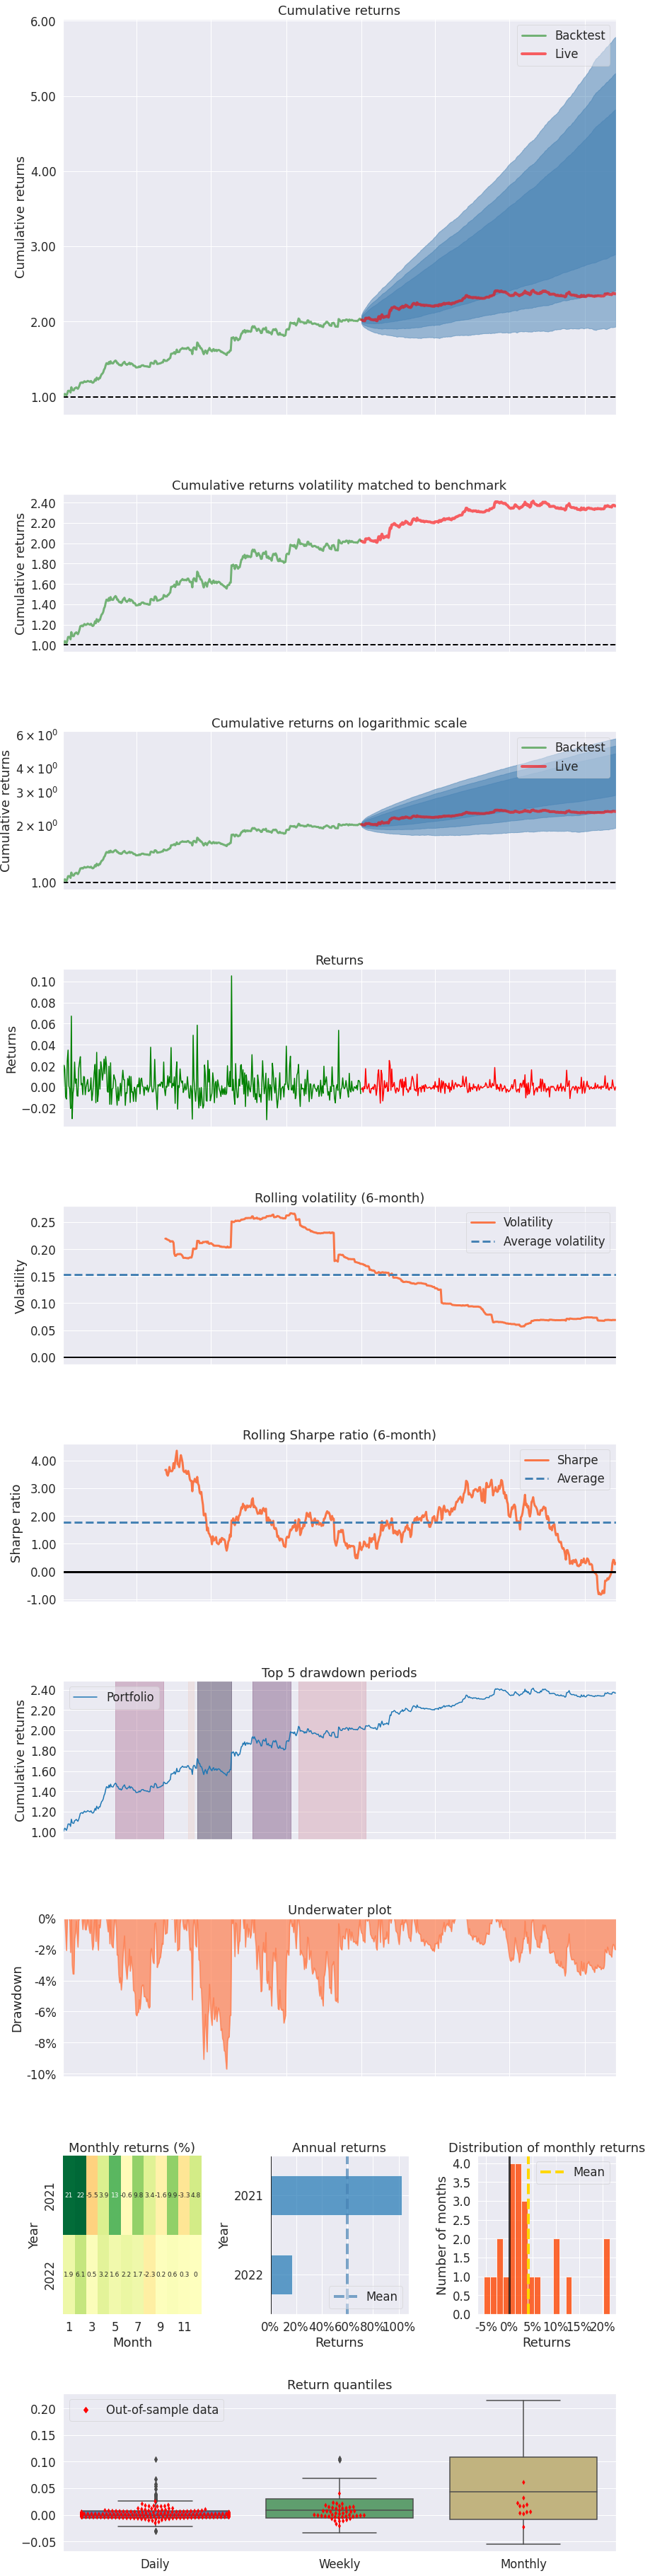

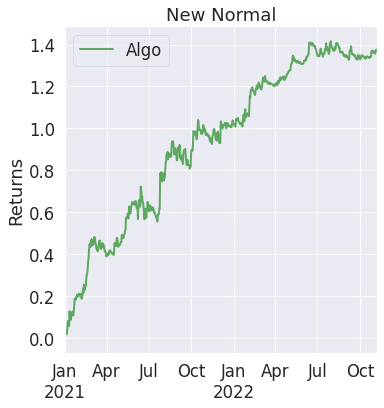

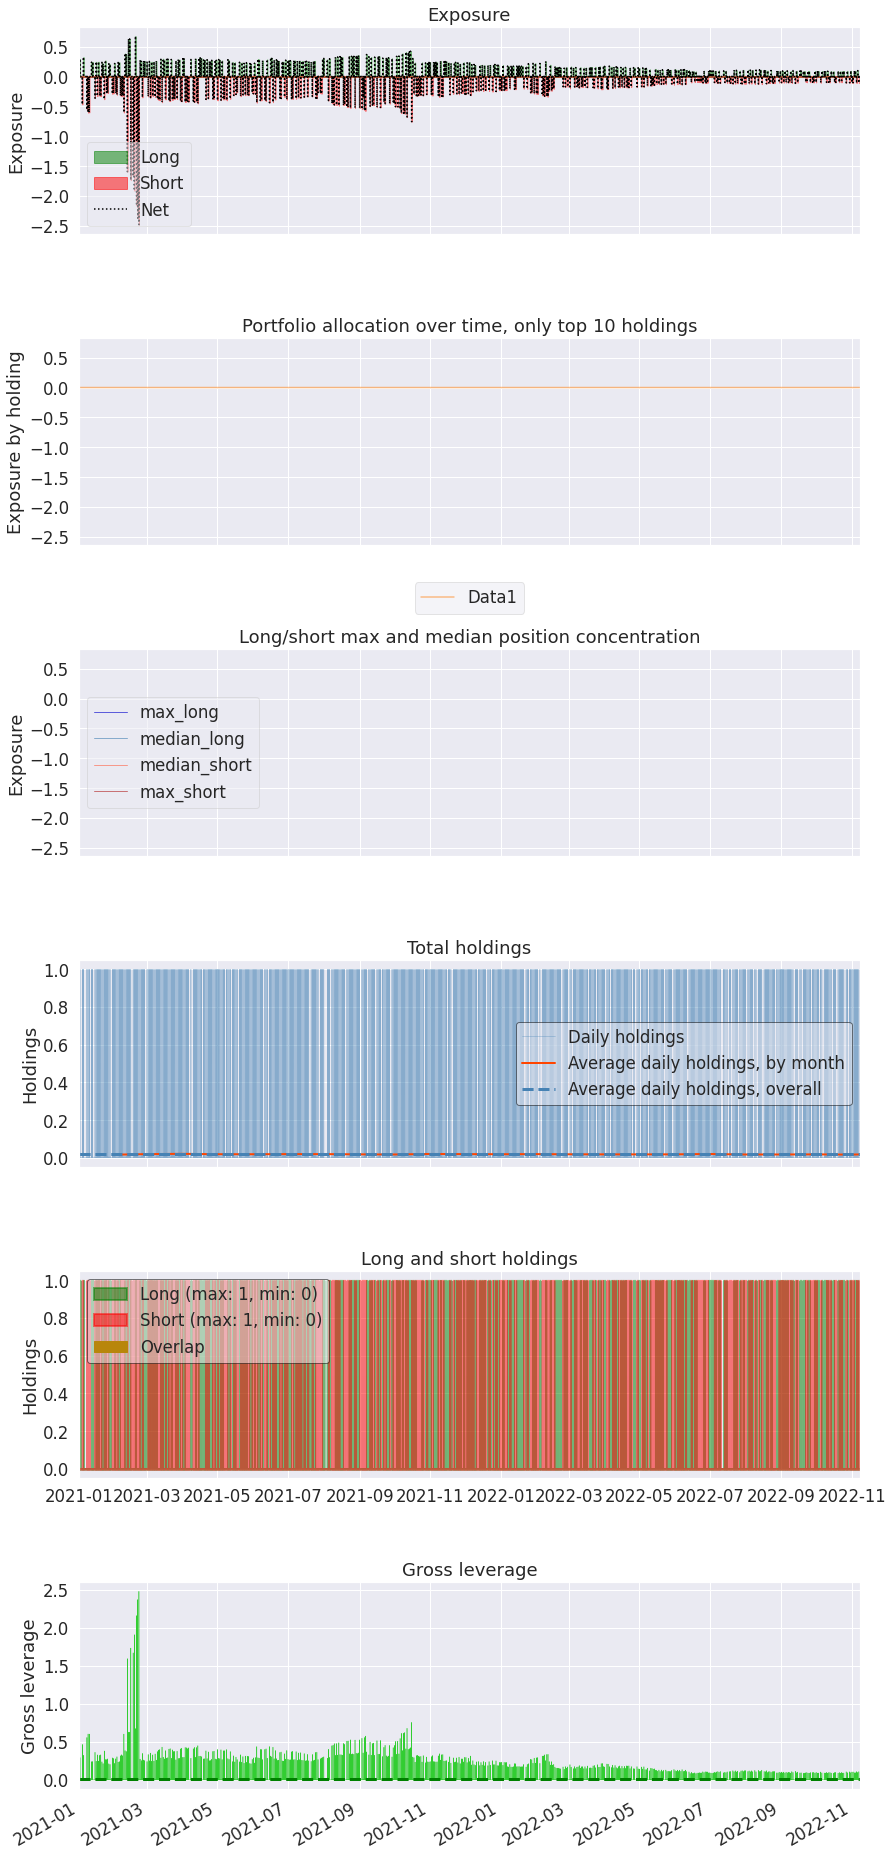

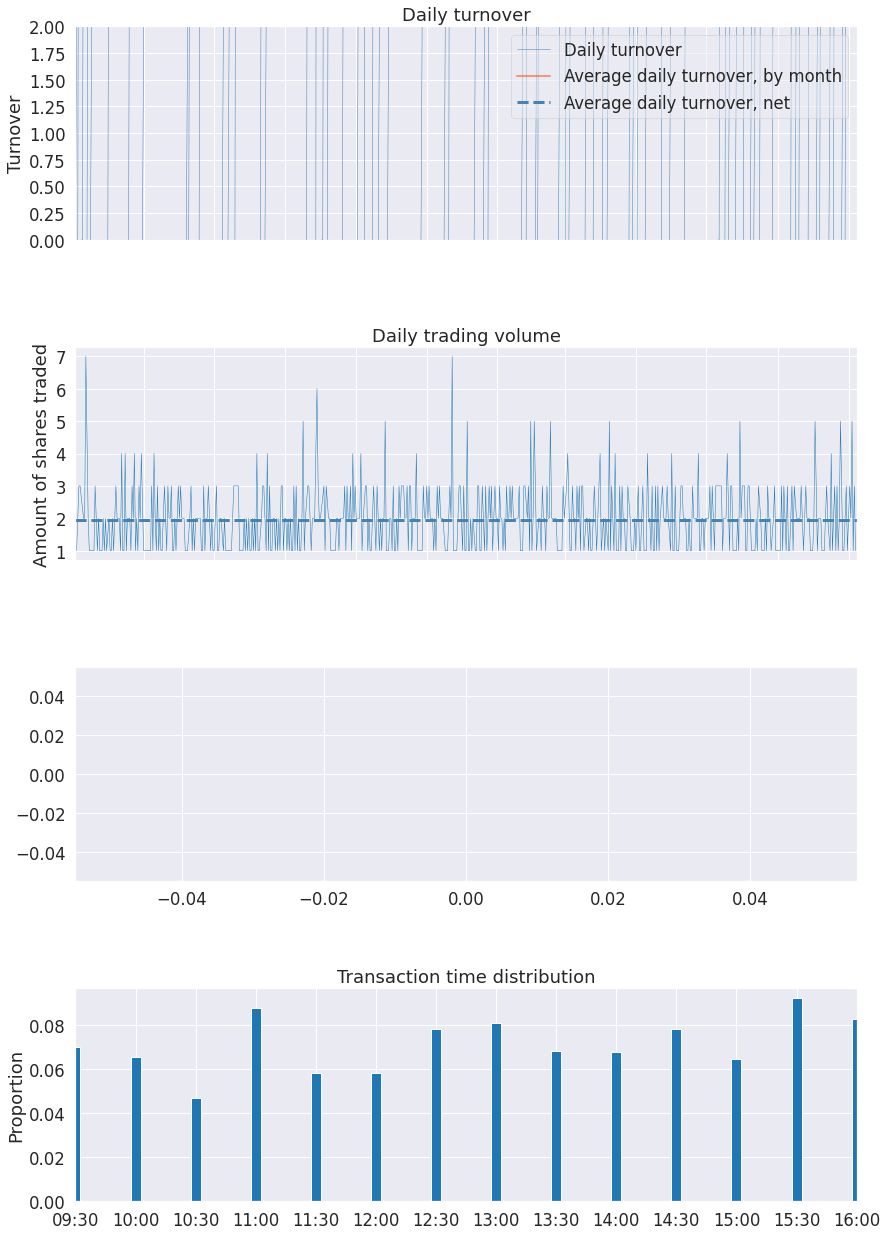

In [130]:
runstrat(['--use-pyfolio'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

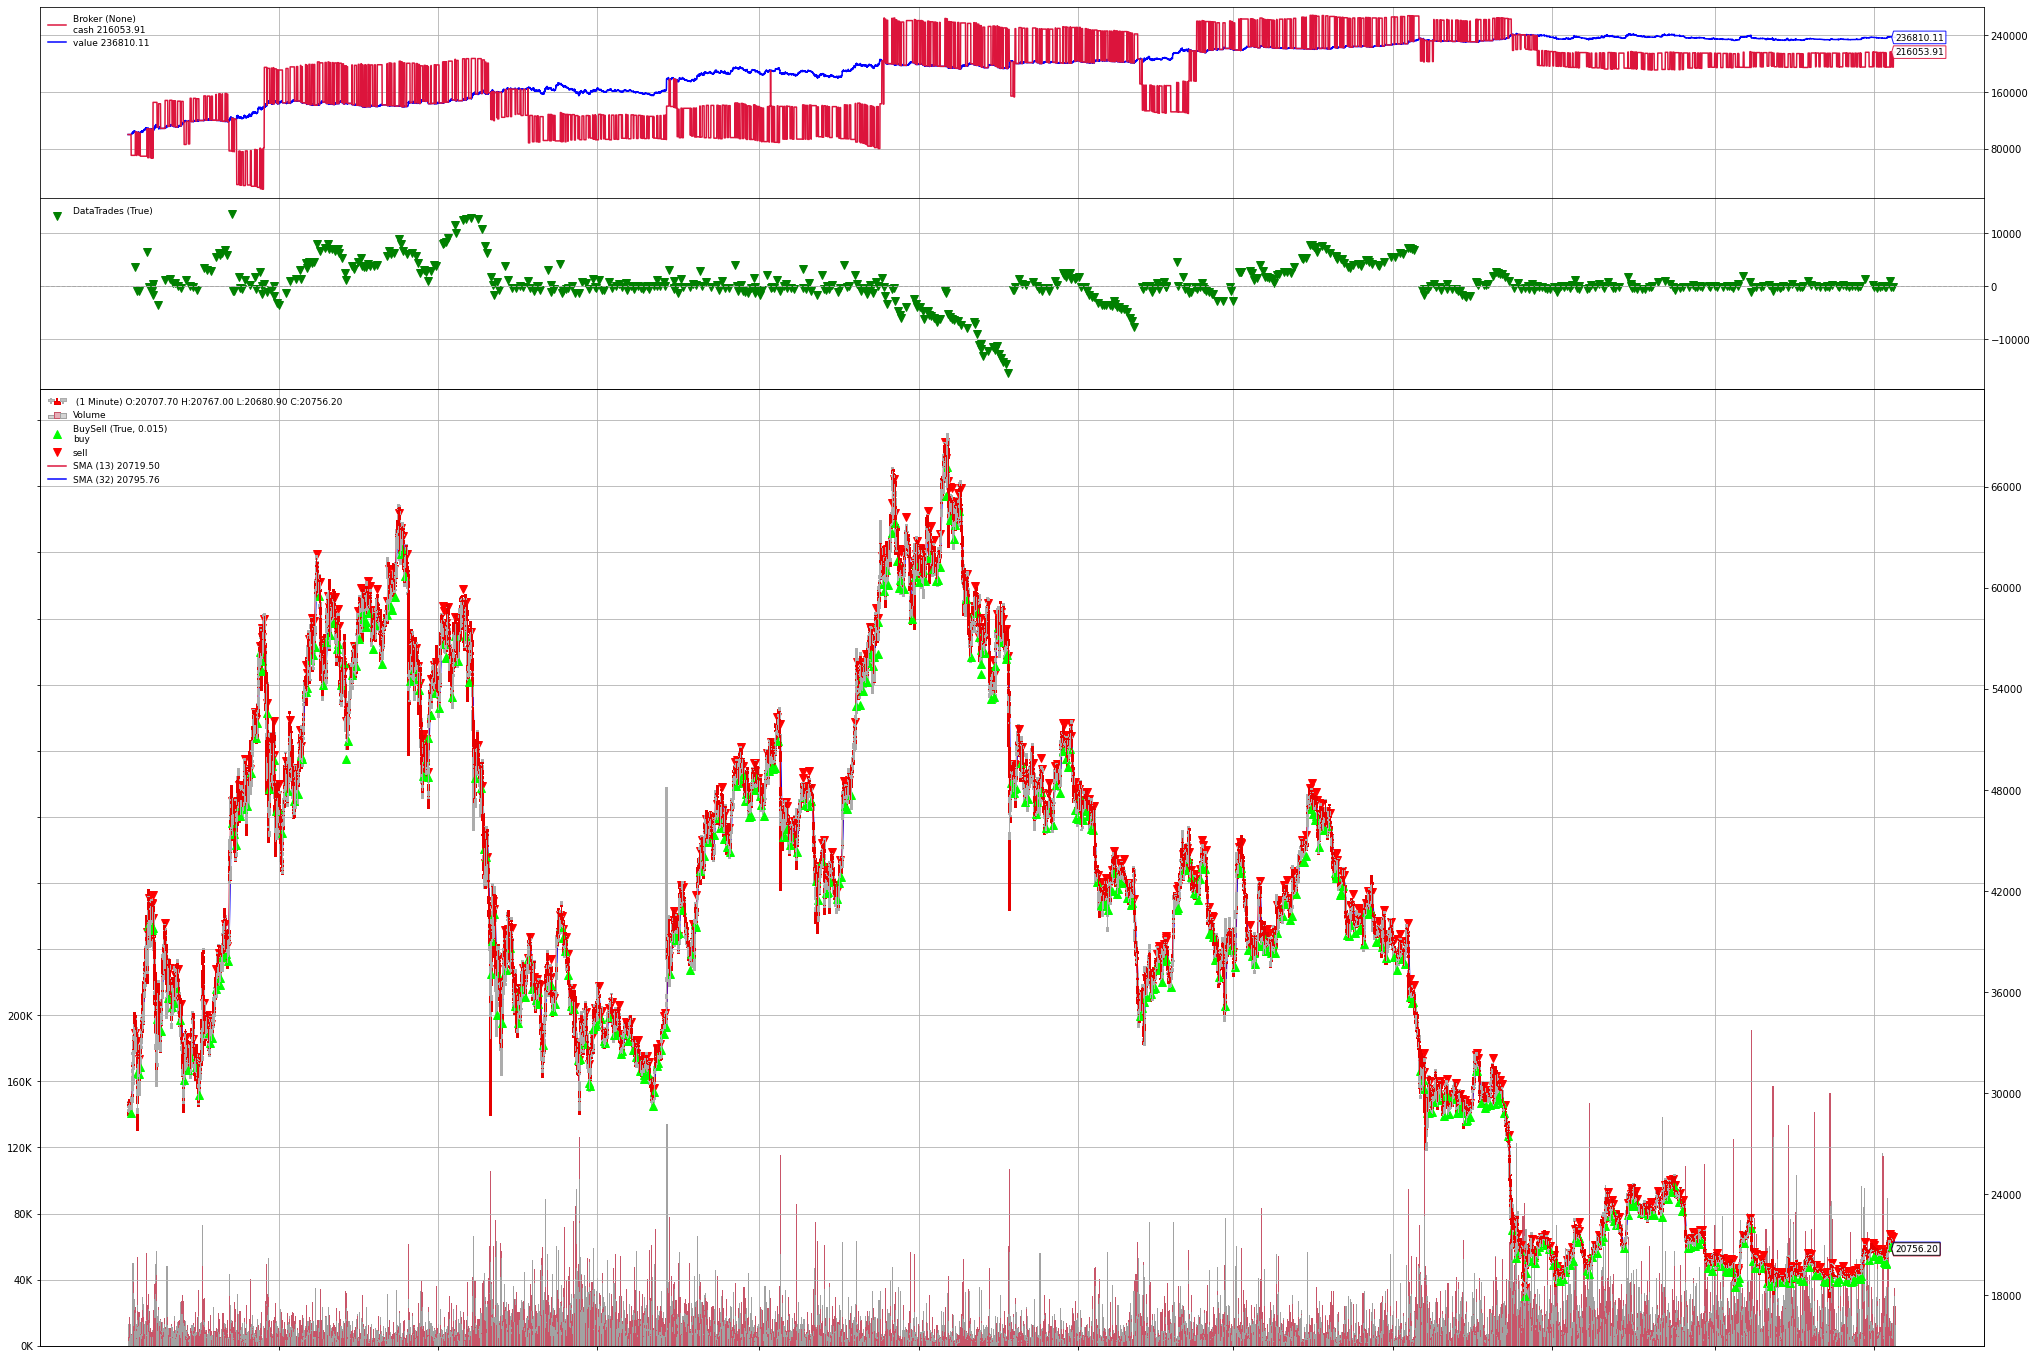

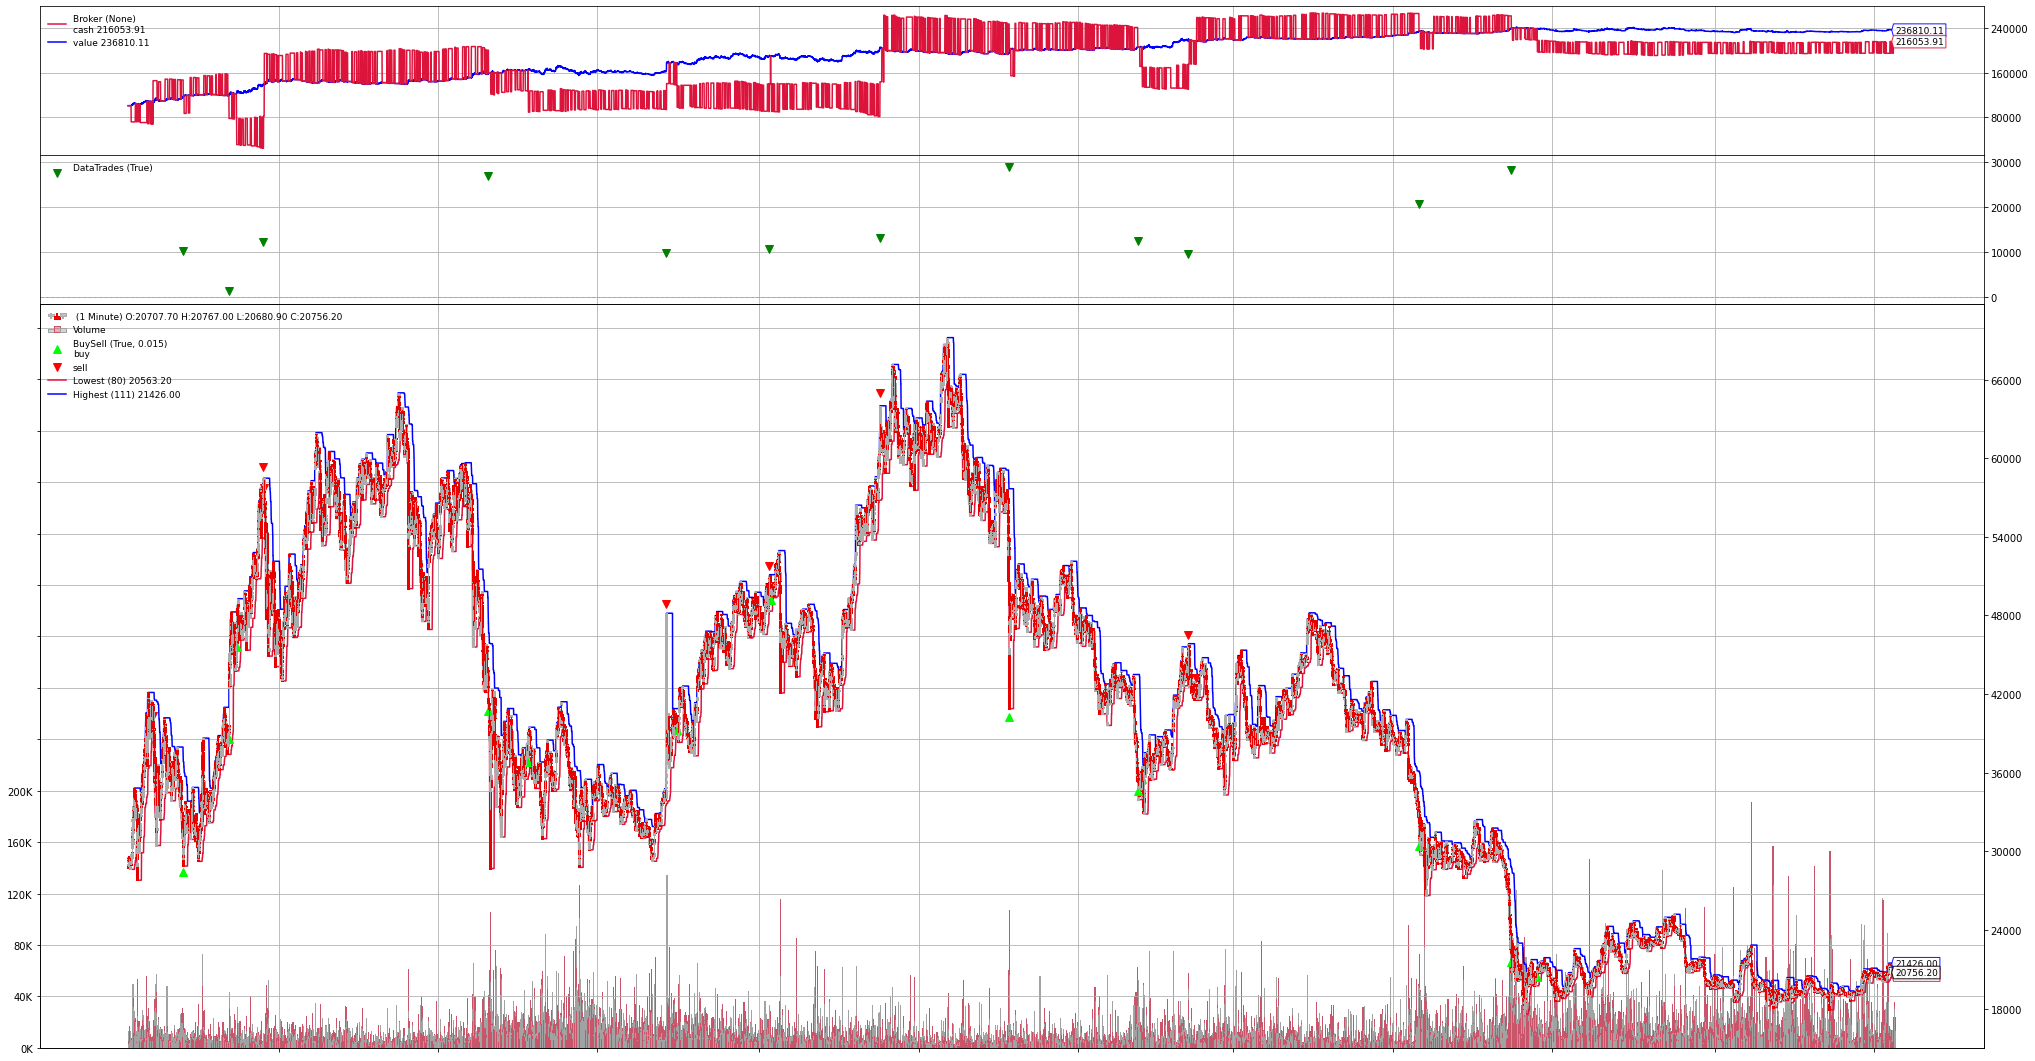

In [131]:
runstrat(['--plot','--plot-style','candle'])